In [37]:
from pandas import read_csv, DataFrame, concat
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam
from keras.constraints import nonneg
from matplotlib import pyplot
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json
from os.path import isfile
import numpy as np 
import sys
import random
import os
from keras.losses import logcosh

In [38]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [39]:
def getXY(filename, scale):

    dataset = read_csv(filename, header=0, index_col=0)
    dataset[["Searches"]] /= 100
    dataset[["Cases"]] = dataset[["Cases"]].apply(lambda x: x*100000/scale, axis=1)


    values = dataset.values.astype("float32")
    total_features = len(values[0])

    n_weeks = 4
    n_features = 2

    reframed = series_to_supervised(values, n_weeks, 1)
    values = reframed.values
    print("Reframed Shape: ", reframed.shape)
    totalFeatures = reframed.shape[1]
    n_obs = n_weeks * n_features

    x, y = values[:, :-2], values[:, -1] # Pick last week's cases as y and drop last week's 

    x = x.reshape((x.shape[0], n_weeks, n_features)) # Reshape as 3-D
    return x, y

In [40]:
def saveModel(model, modelName):
    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    model_json = model.to_json()
    with open(jsonName, "w") as json_file:
        json_file.write(model_json)
    #seralize weights to HDF5
    model.save_weights(h5Name)


In [41]:
def saveModel(model, modelName):
    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    model_json = model.to_json()
    with open(jsonName, "w") as json_file:
        json_file.write(model_json)
    #seralize weights to HDF5
    model.save_weights(h5Name)

In [42]:
def loadOrCreateModel(modelName): 

    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    if(isfile(jsonName) and isfile(h5Name)):

        loaded_model_json = None
        with open(jsonName, "r") as json_file:
            loaded_model_json = json_file.read()

        model = model_from_json(loaded_model_json)
        model.load_weights(h5Name)
        model.compile(loss=[logcosh], optimizer="adam", metrics=["mse"])
        return model
    else:
        model = Sequential()
        model.add(LSTM(256, input_shape=(4, 2), return_sequences=True))
        model.add(LSTM(64, activation="relu", return_sequences=True))
        model.add(LSTM(32, activation="relu", return_sequences=False))

        model.add(Dense(128, activation="relu"))
        model.add(Dense(1, activation='linear', kernel_constraint=nonneg()))
        # model.add(Dense(1, activation="relu", kernel_constraint=nonneg()))
        model.compile(loss=[logcosh], optimizer="adam", metrics=["mse"])
        model.summary()
        return model

In [43]:
#Population values
population = {
    "Chiapas_2016-2018.csv": 5217908,
    "Colima_2016-2018.csv": 711235,
    "Guerrero_2016-2018.csv": 3533251,
    "Hidalgo_2016-2018.csv": 2858359,
    "NuevoLeon_2016-2018.csv": 5119504,
    "Oaxaca_2016-2018.csv": 3967889,
    "QuintanaRoo_2016-2018.csv": 1501562,
    "Tabasco_2016-2018.csv" : 2395272,
    "Veracruz_2016-2018.csv" : 8112505,
    "Yucatan_2016-2018.csv" : 2097175,
}

In [44]:
def ExportPredictions(model, folder, test_files):
    for file in test_files:
        outputName = "Predictions-{}".format(file)
        x, y = getXY("{}/{}".format(dataFolder, file), population[file])
        with open("{}/{}".format(folder, outputName), "w") as outputFile:
            outputFile.write("Value,Prediction,Error\n")
            predictions = model.predict(x)
            y = y.reshape((len(y), 1))
            inv_yPred = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, predictions)
            inv_y = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, y)
            for i in range(len(inv_yPred)):
                yPred = float(inv_yPred[i])
                yReal = float(inv_y[i])
                outputFile.write("{},{},{}\n".format(yReal, yPred, yPred-yReal))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 4, 256)            265216    
_________________________________________________________________
lstm_17 (LSTM)               (None, 4, 64)             82176     
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 364,161
Trainable params: 364,161
Non-trainable params: 0
_________________________________________________________________
Reframed Shape:  (119, 10)
Epoch 1/10
119/119 [==============================] - 4s 37ms/step - loss: 0.2462 - mean_squared_error: 1.699

Epoch 4/10
119/119 [==============================] - 0s 303us/step - loss: 0.0084 - mean_squared_error: 0.0172
Epoch 5/10
119/119 [==============================] - 0s 311us/step - loss: 0.0082 - mean_squared_error: 0.0169
Epoch 6/10
119/119 [==============================] - 0s 303us/step - loss: 0.0082 - mean_squared_error: 0.0169
Epoch 7/10
119/119 [==============================] - 0s 303us/step - loss: 0.0082 - mean_squared_error: 0.0169
Epoch 8/10
119/119 [==============================] - 0s 319us/step - loss: 0.0082 - mean_squared_error: 0.0170
Epoch 9/10
119/119 [==============================] - 0s 336us/step - loss: 0.0082 - mean_squared_error: 0.0171
Epoch 10/10
119/119 [==============================] - 0s 319us/step - loss: 0.0082 - mean_squared_error: 0.0170
Reframed Shape:  (119, 10)
Test RMSE: 14.141
Total [ 749.99999757]
len 119
Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
Test RMSE: 11.623
Total [ 827.00

Epoch 3/10
119/119 [==============================] - 0s 294us/step - loss: 0.0115 - mean_squared_error: 0.0243
Epoch 4/10
119/119 [==============================] - 0s 345us/step - loss: 0.0114 - mean_squared_error: 0.0239
Epoch 5/10
119/119 [==============================] - 0s 345us/step - loss: 0.0112 - mean_squared_error: 0.0235
Epoch 6/10
119/119 [==============================] - 0s 361us/step - loss: 0.0111 - mean_squared_error: 0.0232
Epoch 7/10
119/119 [==============================] - 0s 420us/step - loss: 0.0109 - mean_squared_error: 0.0229
Epoch 8/10
119/119 [==============================] - 0s 487us/step - loss: 0.0109 - mean_squared_error: 0.0227
Epoch 9/10
119/119 [==============================] - 0s 387us/step - loss: 0.0108 - mean_squared_error: 0.0226
Epoch 10/10
119/119 [==============================] - 0s 412us/step - loss: 0.0108 - mean_squared_error: 0.0225
Reframed Shape:  (119, 10)
Epoch 1/10
119/119 [==============================] - 0s 303us/step - loss: 

Epoch 2/10
119/119 [==============================] - 0s 370us/step - loss: 0.0749 - mean_squared_error: 0.2323
Epoch 3/10
119/119 [==============================] - 0s 445us/step - loss: 0.0733 - mean_squared_error: 0.2269
Epoch 4/10
119/119 [==============================] - 0s 319us/step - loss: 0.0700 - mean_squared_error: 0.2159
Epoch 5/10
119/119 [==============================] - 0s 336us/step - loss: 0.0653 - mean_squared_error: 0.2002
Epoch 6/10
119/119 [==============================] - 0s 294us/step - loss: 0.0596 - mean_squared_error: 0.1813
Epoch 7/10
119/119 [==============================] - 0s 303us/step - loss: 0.0544 - mean_squared_error: 0.1640
Epoch 8/10
119/119 [==============================] - 0s 303us/step - loss: 0.0539 - mean_squared_error: 0.1593
Epoch 9/10
119/119 [==============================] - 0s 345us/step - loss: 0.0602 - mean_squared_error: 0.1746
Epoch 10/10
119/119 [==============================] - 0s 336us/step - loss: 0.0622 - mean_squared_error

Reframed Shape:  (119, 10)
Epoch 1/10
119/119 [==============================] - 0s 261us/step - loss: 0.0898 - mean_squared_error: 0.3001
Epoch 2/10
119/119 [==============================] - 0s 328us/step - loss: 0.0694 - mean_squared_error: 0.2006
Epoch 3/10
119/119 [==============================] - 0s 303us/step - loss: 0.0572 - mean_squared_error: 0.1457
Epoch 4/10
119/119 [==============================] - 0s 286us/step - loss: 0.0538 - mean_squared_error: 0.1320
Epoch 5/10
119/119 [==============================] - 0s 303us/step - loss: 0.0548 - mean_squared_error: 0.1360
Epoch 6/10
119/119 [==============================] - 0s 311us/step - loss: 0.0569 - mean_squared_error: 0.1442
Epoch 7/10
119/119 [==============================] - 0s 319us/step - loss: 0.0590 - mean_squared_error: 0.1516
Epoch 8/10
119/119 [==============================] - 0s 319us/step - loss: 0.0604 - mean_squared_error: 0.1568
Epoch 9/10
119/119 [==============================] - 0s 319us/step - loss: 0

Epoch 10/10
119/119 [==============================] - 0s 311us/step - loss: 0.0757 - mean_squared_error: 0.3686
Reframed Shape:  (119, 10)
Epoch 1/10
119/119 [==============================] - 0s 277us/step - loss: 0.0122 - mean_squared_error: 0.0254
Epoch 2/10
119/119 [==============================] - 0s 496us/step - loss: 0.0121 - mean_squared_error: 0.0251
Epoch 3/10
119/119 [==============================] - 0s 303us/step - loss: 0.0119 - mean_squared_error: 0.0249
Epoch 4/10
119/119 [==============================] - 0s 311us/step - loss: 0.0119 - mean_squared_error: 0.0248
Epoch 5/10
119/119 [==============================] - 0s 303us/step - loss: 0.0118 - mean_squared_error: 0.0248
Epoch 6/10
119/119 [==============================] - 0s 378us/step - loss: 0.0118 - mean_squared_error: 0.0247
Epoch 7/10
119/119 [==============================] - 0s 345us/step - loss: 0.0117 - mean_squared_error: 0.0246
Epoch 8/10
119/119 [==============================] - 0s 403us/step - loss: 

Epoch 9/10
119/119 [==============================] - 0s 311us/step - loss: 0.0779 - mean_squared_error: 0.3901
Epoch 10/10
119/119 [==============================] - 0s 303us/step - loss: 0.0775 - mean_squared_error: 0.3879
Reframed Shape:  (119, 10)
Epoch 1/10
119/119 [==============================] - 0s 345us/step - loss: 0.1911 - mean_squared_error: 0.6712
Epoch 2/10
119/119 [==============================] - 0s 429us/step - loss: 0.1886 - mean_squared_error: 0.6602
Epoch 3/10
119/119 [==============================] - 0s 328us/step - loss: 0.1855 - mean_squared_error: 0.6467
Epoch 4/10
119/119 [==============================] - 0s 403us/step - loss: 0.1819 - mean_squared_error: 0.6305
Epoch 5/10
119/119 [==============================] - 0s 319us/step - loss: 0.1775 - mean_squared_error: 0.6110
Epoch 6/10
119/119 [==============================] - 0s 378us/step - loss: 0.1722 - mean_squared_error: 0.5876
Epoch 7/10
119/119 [==============================] - 0s 370us/step - loss: 

Epoch 1/10
119/119 [==============================] - 7s 58ms/step - loss: 0.0368 - mean_squared_error: 0.0910
Epoch 2/10
119/119 [==============================] - 0s 311us/step - loss: 0.0360 - mean_squared_error: 0.0891
Epoch 3/10
119/119 [==============================] - 0s 303us/step - loss: 0.0354 - mean_squared_error: 0.0875
Epoch 4/10
119/119 [==============================] - 0s 328us/step - loss: 0.0348 - mean_squared_error: 0.0859
Epoch 5/10
119/119 [==============================] - 0s 303us/step - loss: 0.0342 - mean_squared_error: 0.0843
Epoch 6/10
119/119 [==============================] - 0s 303us/step - loss: 0.0337 - mean_squared_error: 0.0827
Epoch 7/10
119/119 [==============================] - 0s 303us/step - loss: 0.0332 - mean_squared_error: 0.0812
Epoch 8/10
119/119 [==============================] - 0s 328us/step - loss: 0.0328 - mean_squared_error: 0.0799
Epoch 9/10
119/119 [==============================] - 0s 336us/step - loss: 0.0326 - mean_squared_error: 

Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
Test RMSE: 32.251
Total [ 1989.99999691]
len 119
Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
Reframed Shape:  (119, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 4, 256)            265216    
_________________________________________________________________
lstm_38 (LSTM)               (None, 4, 64)             82176     
_________________________________________________________________
lstm_39 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 364,161
Trainable para

Epoch 2/10
119/119 [==============================] - 0s 353us/step - loss: 0.0082 - mean_squared_error: 0.0169
Epoch 3/10
119/119 [==============================] - 0s 361us/step - loss: 0.0081 - mean_squared_error: 0.0166
Epoch 4/10
119/119 [==============================] - 0s 395us/step - loss: 0.0080 - mean_squared_error: 0.0164
Epoch 5/10
119/119 [==============================] - 0s 294us/step - loss: 0.0079 - mean_squared_error: 0.0161
Epoch 6/10
119/119 [==============================] - 0s 336us/step - loss: 0.0078 - mean_squared_error: 0.0160
Epoch 7/10
119/119 [==============================] - 0s 311us/step - loss: 0.0077 - mean_squared_error: 0.0159
Epoch 8/10
119/119 [==============================] - 0s 353us/step - loss: 0.0077 - mean_squared_error: 0.0158
Epoch 9/10
119/119 [==============================] - 0s 353us/step - loss: 0.0077 - mean_squared_error: 0.0158
Epoch 10/10
119/119 [==============================] - 0s 353us/step - loss: 0.0077 - mean_squared_error

Reframed Shape:  (119, 10)
Epoch 1/10
119/119 [==============================] - 0s 328us/step - loss: 0.0473 - mean_squared_error: 0.1142
Epoch 2/10
119/119 [==============================] - 0s 403us/step - loss: 0.0485 - mean_squared_error: 0.1179
Epoch 3/10
119/119 [==============================] - 0s 420us/step - loss: 0.0494 - mean_squared_error: 0.1207
Epoch 4/10
119/119 [==============================] - 0s 445us/step - loss: 0.0499 - mean_squared_error: 0.1224
Epoch 5/10
119/119 [==============================] - 0s 319us/step - loss: 0.0501 - mean_squared_error: 0.1230
Epoch 6/10
119/119 [==============================] - 0s 319us/step - loss: 0.0500 - mean_squared_error: 0.1224
Epoch 7/10
119/119 [==============================] - 0s 370us/step - loss: 0.0496 - mean_squared_error: 0.1210
Epoch 8/10
119/119 [==============================] - 0s 445us/step - loss: 0.0490 - mean_squared_error: 0.1190
Epoch 9/10
119/119 [==============================] - 0s 597us/step - loss: 0

Epoch 10/10
119/119 [==============================] - 0s 345us/step - loss: 0.0565 - mean_squared_error: 0.1643
Reframed Shape:  (119, 10)
Epoch 1/10
119/119 [==============================] - 0s 269us/step - loss: 0.0282 - mean_squared_error: 0.0697
Epoch 2/10
119/119 [==============================] - 0s 294us/step - loss: 0.0281 - mean_squared_error: 0.0696
Epoch 3/10
119/119 [==============================] - 0s 319us/step - loss: 0.0280 - mean_squared_error: 0.0695
Epoch 4/10
119/119 [==============================] - 0s 311us/step - loss: 0.0279 - mean_squared_error: 0.0692
Epoch 5/10
119/119 [==============================] - 0s 345us/step - loss: 0.0277 - mean_squared_error: 0.0687
Epoch 6/10
119/119 [==============================] - 0s 353us/step - loss: 0.0275 - mean_squared_error: 0.0682
Epoch 7/10
119/119 [==============================] - 0s 303us/step - loss: 0.0272 - mean_squared_error: 0.0675
Epoch 8/10
119/119 [==============================] - 0s 361us/step - loss: 

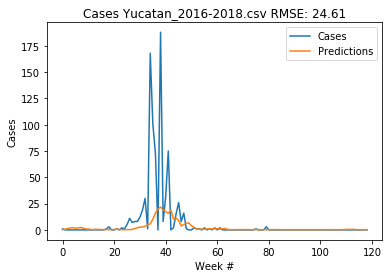

In [47]:
for i in range(10):
    os.mkdir("Experiments/{}".format(i))
    #Splits the files into 7-Train 3-Test
    dataFolder = "../../../data/Mexico/processed_data"
    files = os.listdir(dataFolder)
    train_files = random.sample(files, 7)
    test_files = list(filter(lambda x: x not in train_files, files))
    model = loadOrCreateModel("Model{}".format(i))
    
    for file in train_files:
        x,y = getXY("{}/{}".format(dataFolder, file), population[file])
        model.fit(x, y,
                 epochs = 10,
                 batch_size=x.shape[0],
                 verbose=1, 
                 shuffle=False)

    #Evaluate model
    for file in test_files:
        x, y = getXY("{}/{}".format(dataFolder, file), population[file])
        predictions = model.predict(x)
        y = y.reshape((len(y), 1))

        inv_yPred = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, predictions)
        inv_y = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, y)

        rmse = sqrt(mean_squared_error(inv_y, inv_yPred))

        print('Test RMSE: %.3f' % rmse)
        print("Total", sum(inv_y))
        print("len", len(inv_y))
        pyplot.clf()
        pyplot.title("Cases {} RMSE: {:.2f}".format(file, rmse))
        pyplot.ylabel("Cases")
        pyplot.xlabel("Week #")
        pyplot.plot(inv_y, label="Cases")
        pyplot.plot(inv_yPred, label="Predictions")
        pyplot.legend()
        pngName = file.split(".")[0]
        pyplot.savefig('Experiments/{}/{}.png'.format(i, pngName))
        
        saveModel(model, "Experiments/{0}/model-{0}".format(i))
        ExportPredictions(model, "Experiments/{}".format(i), test_files)
    